Lenet

In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing CIFAR-10 images
])


In [19]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [20]:
print(f'Training set size: {len(trainset)} images')
print(f'Test set size: {len(testset)} images')
print(f'Number of classes: {len(trainset.classes)}')
print(f'Class names: {trainset.classes}')
print(f'Class map name to value {trainset.class_to_idx}')


Training set size: 50000 images
Test set size: 10000 images
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Class map name to value {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


In [21]:
image, label = trainset[0]

In [22]:
image.size()

torch.Size([3, 32, 32])

Model Archt.

In [23]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=2)  # Output: (6, 32, 32)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)  # Output: (16, 28, 28)
        self.bn2 = nn.BatchNorm2d(16)  # Batch normalization for conv2
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)  # Output: (120, 24, 24)
        self.bn3 = nn.BatchNorm2d(120)  # Batch normalization for conv3

        # Fully connected layers
        self.fc1 = nn.Linear(120 * 2 * 2, 84)  # Output: (84)
        self.bn4 = nn.BatchNorm1d(84)  # Batch normalization for fc1
        self.fc2 = nn.Linear(84, 10)  # Output: (10)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  # Reduces dimensions by half

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        # Initialize convolutional layers
        nn.init.xavier_normal_(self.conv1.weight)  # Xavier initialization for conv1
        nn.init.xavier_normal_(self.conv2.weight)  # Xavier initialization for conv2
        nn.init.xavier_normal_(self.conv3.weight)  # Xavier initialization for conv3
        # Biases for convolutional layers (usually initialized to zero)
        nn.init.constant_(self.conv1.bias, 0)
        nn.init.constant_(self.conv2.bias, 0)
        nn.init.constant_(self.conv3.bias, 0)

        # Initialize fully connected layers
        nn.init.xavier_normal_(self.fc1.weight)  # Xavier initialization for fc1
        nn.init.xavier_normal_(self.fc2.weight)  # Xavier initialization for fc2
        # Biases for fully connected layers (usually initialized to zero)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.constant_(self.fc2.bias, 0)

    def forward(self, x):
        # Apply convolutional layer 1
        x = self.conv1(x)  # Input: (3, 32, 32) -> Output: (6, 32, 32)
        x = self.bn1(x)
        x = F.relu(x)      # ReLU activation: (6, 32, 32)
        x = self.pool(x)   # Max pooling: (6, 32, 32) -> (6, 16, 16)

        # Apply convolutional layer 2
        x = self.conv2(x)  # Input: (6, 16, 16) -> Output: (16, 12, 12)
        x = self.bn2(x)
        x = F.relu(x)      # ReLU activation: (16, 12, 12)
        x = self.pool(x)   # Max pooling: (16, 12, 12) -> (16, 6, 6)

        # Apply convolutional layer 3
        x = self.conv3(x)  # Input: (16, 6, 6) -> Output: (120, 2, 2)
        x = self.bn3(x)
        x = F.relu(x)      # ReLU activation: (120, 2, 2)

        # Flatten the tensor for fully connected layers
        x = x.view(-1, 120 * 2 * 2)  # Flatten: Input: (120, 2, 2) -> Output: (480)

        # Apply fully connected layer 1
        x = self.fc1(x)    # Input: (480) -> Output: (84)
        x = self.bn4(x)
        x = F.relu(x)      # ReLU activation: (84)

        # Apply fully connected layer 2
        x = self.fc2(x)    # Input: (84) -> Output: (10)
        x = torch.softmax(x, dim=1)
        return x


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet5().to(device)

In [25]:
# # Test with a dummy input
# dummy_input = torch.randn(1, 3, 32, 32)  # Batch size of 1, 3 channels, 32x32 image
# logits = model(dummy_input)
# print(logits)

# Convert logits to probabilities if needed (for evaluation or inference)
# _, predicted_class = torch.max(logits, 1)

In [26]:
from torchsummary import summary
summary(model,input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             456
       BatchNorm2d-2            [-1, 6, 32, 32]              12
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 16, 12, 12]           2,416
       BatchNorm2d-5           [-1, 16, 12, 12]              32
         MaxPool2d-6             [-1, 16, 6, 6]               0
            Conv2d-7            [-1, 120, 2, 2]          48,120
       BatchNorm2d-8            [-1, 120, 2, 2]             240
            Linear-9                   [-1, 84]          40,404
      BatchNorm1d-10                   [-1, 84]             168
           Linear-11                   [-1, 10]             850
Total params: 92,698
Trainable params: 92,698
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [27]:
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer with learning rate 0.001

In [28]:
train_losses = []
test_losses = []
epochs = []
import matplotlib.pyplot as plt
def plot_losses(epochs, train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b', label="Train Loss")
    plt.plot(epochs, test_losses, 'r', label="Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [29]:
n_epochs = 5
from tqdm import tqdm

for epoch in tqdm(range(n_epochs)):
  start_time = time.time()
  model.train()
  train_loss = 0
  for batch_idx , (data,target) in enumerate(trainloader):
    data , target  = data.to(device) , target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()*data.size(0)

  train_loss /= len(trainloader.dataset)  # average loss for epoch
  train_losses.append(train_loss)
  epochs.append(epoch + 1)


  # Testing the loss
  model.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data , target in testloader:
      data , target  = data.to(device) , target.to(device)
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item() * data.size(0)  # accumulate loss
      _, predicted = torch.max(output.data, 1)
      correct += (predicted == target).sum().item()

  test_loss /= len(testloader.dataset)  # average loss for epoch
  test_losses.append(test_loss)
  end_time = time.time()  # End timing
  epoch_duration = end_time - start_time  # Duration of the epoch
  print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {100 * correct / len(testloader.dataset):.2f}%')


 20%|██        | 1/5 [00:17<01:08, 17.20s/it]

Epoch 1/5, Train Loss: 2.1334, Test Loss: 2.0521, Accuracy: 42.99%


 40%|████      | 2/5 [00:34<00:50, 16.98s/it]

Epoch 2/5, Train Loss: 2.0192, Test Loss: 1.9806, Accuracy: 50.14%


 60%|██████    | 3/5 [00:50<00:33, 16.70s/it]

Epoch 3/5, Train Loss: 1.9627, Test Loss: 1.9475, Accuracy: 53.37%


 80%|████████  | 4/5 [01:14<00:19, 19.56s/it]

Epoch 4/5, Train Loss: 1.9248, Test Loss: 1.9215, Accuracy: 56.02%


100%|██████████| 5/5 [01:31<00:00, 18.31s/it]

Epoch 5/5, Train Loss: 1.8972, Test Loss: 1.9089, Accuracy: 56.45%


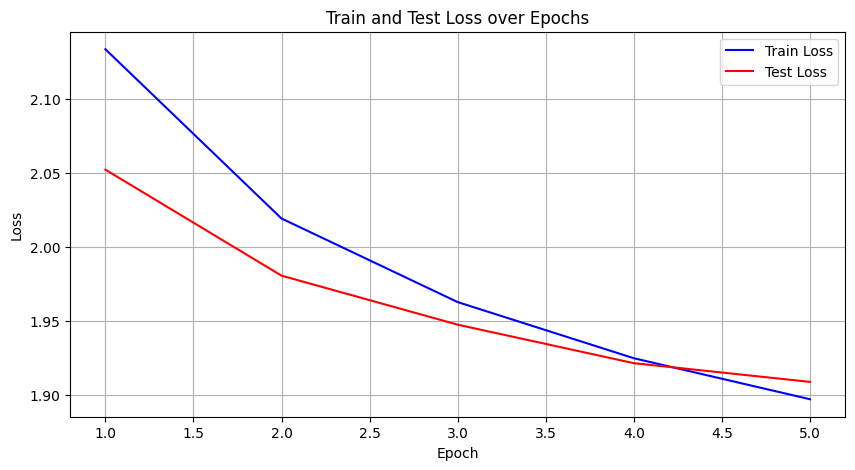

In [30]:
# Plot losses
plot_losses(epochs, train_losses, test_losses)